# Closer look at Logistic Regression and LDA

**Initial edit:** *Lukas Vlcek, 2019-03-07*

* LogisticRegression and LDA performed well and were most robust (out of SVC, LDA, QDA, and LogReg)
* This is a closer look at its parameters

## Setup

In [1]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

In [21]:
# basic libraries
import os
from itertools import combinations

# ML
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# project directories
data_raw = '../data/raw'
data_interim = '../data/interim'
data_processed = '../data/processed'
reports_dir = '../reports'
src_dir = '../src'

## Read data

In [4]:
# import CSV (which was exported from Excel), in need for a serious cleanup
df_xy = pd.read_csv(os.path.join(data_interim, 'alloys_model_ready.csv'))

In [5]:
df_xy.lattice = df_xy.lattice.astype('category')
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 8 columns):
density    355 non-null float64
DH_mix     355 non-null float64
DS_mix     355 non-null float64
T_m        355 non-null float64
delta      355 non-null float64
D_elneg    355 non-null float64
VEC        355 non-null float64
lattice    355 non-null category
dtypes: category(1), float64(7)
memory usage: 20.0 KB


In [6]:
df_xy.head()

,density,DH_mix,DS_mix,T_m,delta,D_elneg,VEC,lattice
0,14.88,-6.0,5.76,1286.13,0.35,0.31,11.0,FCC
1,8.37,-1.0,5.76,1789.50,0.79,0.03,8.5,FCC
2,8.90,0.0,5.76,1748.00,0.00,0.02,9.5,FCC
3,8.91,4.0,5.76,1542.88,1.19,0.01,10.5,FCC
4,8.37,-2.0,5.76,1769.50,0.79,0.04,9.0,FCC


## Prepare data for simple modeling

In [7]:
cols = list(df_xy.columns)
cols.remove('lattice')

In [8]:
X = df_xy[cols].values
y = df_xy['lattice'].cat.codes.values

In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

** Logistic Regression **

In [10]:
lreg = LogisticRegression(solver='lbfgs')
lreg.fit(X_train, y_train)
print('Accuracy on the training data:', lreg.score(X_train, y_train))
print('Accuracy on the testing data:', lreg.score(X_test, y_test))

Accuracy on the training data: 0.9154929577464789
Accuracy on the testing data: 0.9014084507042254


In [11]:
param_grid_lreg = {
        #'multi_class':['multinomial', 'ovr'],
        'C':list(np.logspace(0.001, 1, 40)),
        #'penalty':['l1','l2']
}
grid_lreg = GridSearchCV(lreg, param_grid=param_grid_lreg, cv=5)

grid_lreg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1.0023052380778996, 1.0632010200800628, 1.1277965695031429, 1.196316668401312, 1.268999755625544, 1.3460987565522111, 1.4278819632224482, 1.5146339679550196, 1.6066566536815126, 1.7042702444500666, 1.8078144197532175, 1.9176494965575381, 2.0341576831483477, 2.1577444091526665, 2.28...7.44600077222509, 7.898387951885941, 8.378260242894736, 8.887287523134345, 9.427241125130058, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
print('Accuracy on the training data:', grid_lreg.score(X_train, y_train))
print('Accuracy on the testing data:', grid_lreg.score(X_test, y_test))

# Identify optimal parameters
mean_scores_lreg = np.array(grid_lreg.cv_results_['mean_test_score']).reshape(40)
print('Maximum score:', mean_scores_lreg.max())

#print(mean_scores)
best_index = np.unravel_index(np.argmax(mean_scores_lreg, axis=None), mean_scores_lreg.shape)
print('Best hyperparameters:')
grid_list_lreg = sorted(param_grid_lreg)
#print(grid_list)
#print(best_index)
for i, j in enumerate(best_index):
    print(' ', grid_list_lreg[i],':', param_grid_lreg[grid_list_lreg[i]][j])

Accuracy on the training data: 0.9154929577464789
Accuracy on the testing data: 0.9014084507042254
Maximum score: 0.9119718309859155
Best hyperparameters:
  C : 1.4278819632224482


In [13]:
y_pred = grid_lreg.predict(X)
df_out_lr = df_xy.assign(pred=y_pred)
df_out_lr = df_out_lr.assign(orig=y)

df_out_lr.pred = df_out_lr.pred.astype('category')
df_out_lr.pred = df_out_lr.pred.cat.rename_categories({1:'FCC', 0:'BCC', 2:'HCP', 4:'multi-phase', 3:'amorphous'})

## LDA

In [14]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)
print('Accuracy on the training data:', lda.score(X_train, y_train))
print('Accuracy on the testing data:', lda.score(X_test, y_test))

Accuracy on the training data: 0.9084507042253521
Accuracy on the testing data: 0.9014084507042254


In [15]:
param_grid = {
        'shrinkage':list(np.linspace(0.0, 0.9, 20)),
}
grid_lda = GridSearchCV(lda, param_grid=param_grid, cv=5)
grid_lda.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='lsqr', store_covariance=False, tol=0.0001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'shrinkage': [0.0, 0.04736842105263158, 0.09473684210526316, 0.14210526315789473, 0.18947368421052632, 0.2368421052631579, 0.28421052631578947, 0.3315789473684211, 0.37894736842105264, 0.4263157894736842, 0.4736842105263158, 0.5210526315789474, 0.5684210526315789, 0.6157894736842106, 0.6631578947368422, 0.7105263157894737, 0.7578947368421053, 0.8052631578947369, 0.8526315789473684, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
print('Accuracy on the training data:', grid_lda.score(X_train, y_train))
print('Accuracy on the testing data:', grid_lda.score(X_test, y_test))

# Identify optimal parameters
mean_scores = np.array(grid_lda.cv_results_['mean_test_score'])#.reshape(20)
print('Maximum score:', mean_scores.max())
print(mean_scores)
best_index = np.unravel_index(np.argmax(mean_scores, axis=None), mean_scores.shape)
print('Best hyperparameters:')
grid_list = sorted(param_grid)
#print(grid_list)
#print(best_index)
for i, j in enumerate(best_index):
    print(' ', grid_list[i],':', param_grid[grid_list[i]][j])

Accuracy on the training data: 0.9084507042253521
Accuracy on the testing data: 0.9014084507042254
Maximum score: 0.8943661971830986
[0.8943662  0.73591549 0.71478873 0.71830986 0.71830986 0.72183099
 0.72535211 0.73591549 0.73239437 0.73591549 0.73591549 0.73591549
 0.73943662 0.73239437 0.73591549 0.72887324 0.72887324 0.72535211
 0.6971831  0.69014085]
Best hyperparameters:
  shrinkage : 0.0


In [17]:
y_pred = grid_lda.predict(X)
df_out_lda = df_xy.assign(pred=y_pred)
df_out_lda = df_out_lda.assign(orig=y)

df_out_lda.pred = df_out_lda.pred.astype('category')
df_out_lda.pred = df_out_lda.pred.cat.rename_categories({1:'FCC', 0:'BCC', 2:'HCP', 4:'multi-phase', 3:'amorphous'})

In [18]:
# Compare predictions of LogReg and LDA
plt.style.use('ggplot')

def compare_predictions(xlabel, ylabel):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,10), sharey=True)

    sns.scatterplot(x=xlabel, y=ylabel, hue='lattice', data=df_out_lda, ax=axs[0], s=120)
    axs[0].set_title('TARGET', fontsize=30)
    axs[0].set_xlabel(xlabel, fontsize=30)
    axs[0].set_ylabel(ylabel, fontsize=30)
    axs[0].legend(fontsize=20)

    sns.scatterplot(x=xlabel, y=ylabel, hue='pred', data=df_out_lr, ax=axs[1], s=120)
    axs[1].set_title('Method: LogReg', fontsize=30)
    axs[1].set_xlabel(xlabel, fontsize=30)
    axs[1].legend(fontsize=20)

    sns.scatterplot(x=xlabel, y=ylabel, hue='pred', data=df_out_lda, ax=axs[2], s=120)
    axs[2].set_title('Method: LDA', fontsize=30)
    axs[2].set_xlabel(xlabel, fontsize=30)
    axs[2].legend(fontsize=20)

    plt.tight_layout()

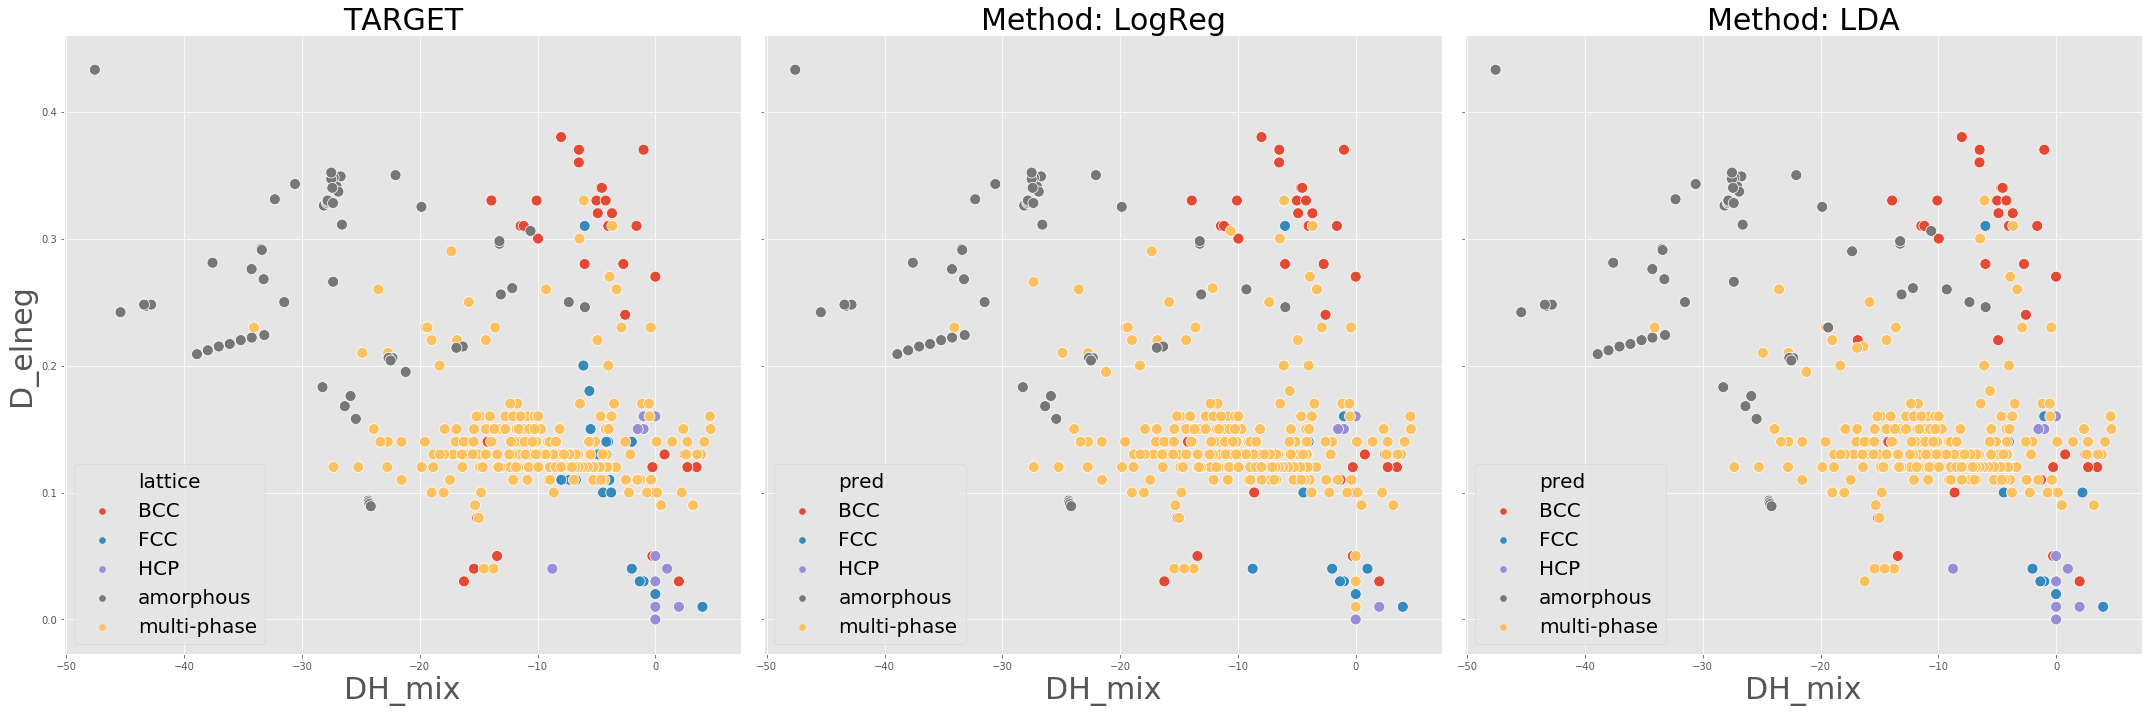

In [19]:
compare_predictions('DH_mix', 'D_elneg')

In [27]:
# cols = ['density', 'DH_mix', 'DS_mix', 'T_m', 'delta', 'D_elneg', 'VEC']
# for x, y in combinations(cols, 2):
#     compare_predictions(x, y)

## LDA dimensionality reduction

In [56]:
X = df_xy[cols].values
y = df_xy['lattice'].cat.codes.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

In [59]:
lda_dr = LinearDiscriminantAnalysis(n_components=3)
lda_dr.fit(X_train, y_train)
print('Accuracy on the training data:', lda_dr.score(X_train, y_train))
#print('Accuracy on the testing data:', lda_dr.score(X_test, y_test))

Accuracy on the training data: 0.9049295774647887


In [70]:
y_pred = lda_dr.predict(X)
df_out_lda = df_xy.assign(pred=y_pred)
df_out_lda = df_out_lda.assign(orig=y)

df_out_lda.pred = df_out_lda.pred.astype('category')
df_out_lda.pred = df_out_lda.pred.cat.rename_categories({1:'FCC', 0:'BCC', 2:'HCP', 4:'multi-phase', 3:'amorphous'})

In [71]:
X_lda = lda_dr.fit_transform(X, y)

In [81]:
def plot_pairviews(xc, yc): 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30,15), sharey=True)

    sns.scatterplot(x=X_lda[:,xc], y=X_lda[:,yc], hue='lattice', data=df_out_lda, ax=axs[0], s=120)
    axs[0].set_title('TARGET (2d-projection)', fontsize=30)
    axs[0].legend(fontsize=20)

    sns.scatterplot(x=X_lda[:,xc], y=X_lda[:,yc], hue='pred', data=df_out_lr, ax=axs[1], s=120)
    axs[1].set_title('Method: LDA (2d-projection)', fontsize=30)
    axs[1].legend(fontsize=20)

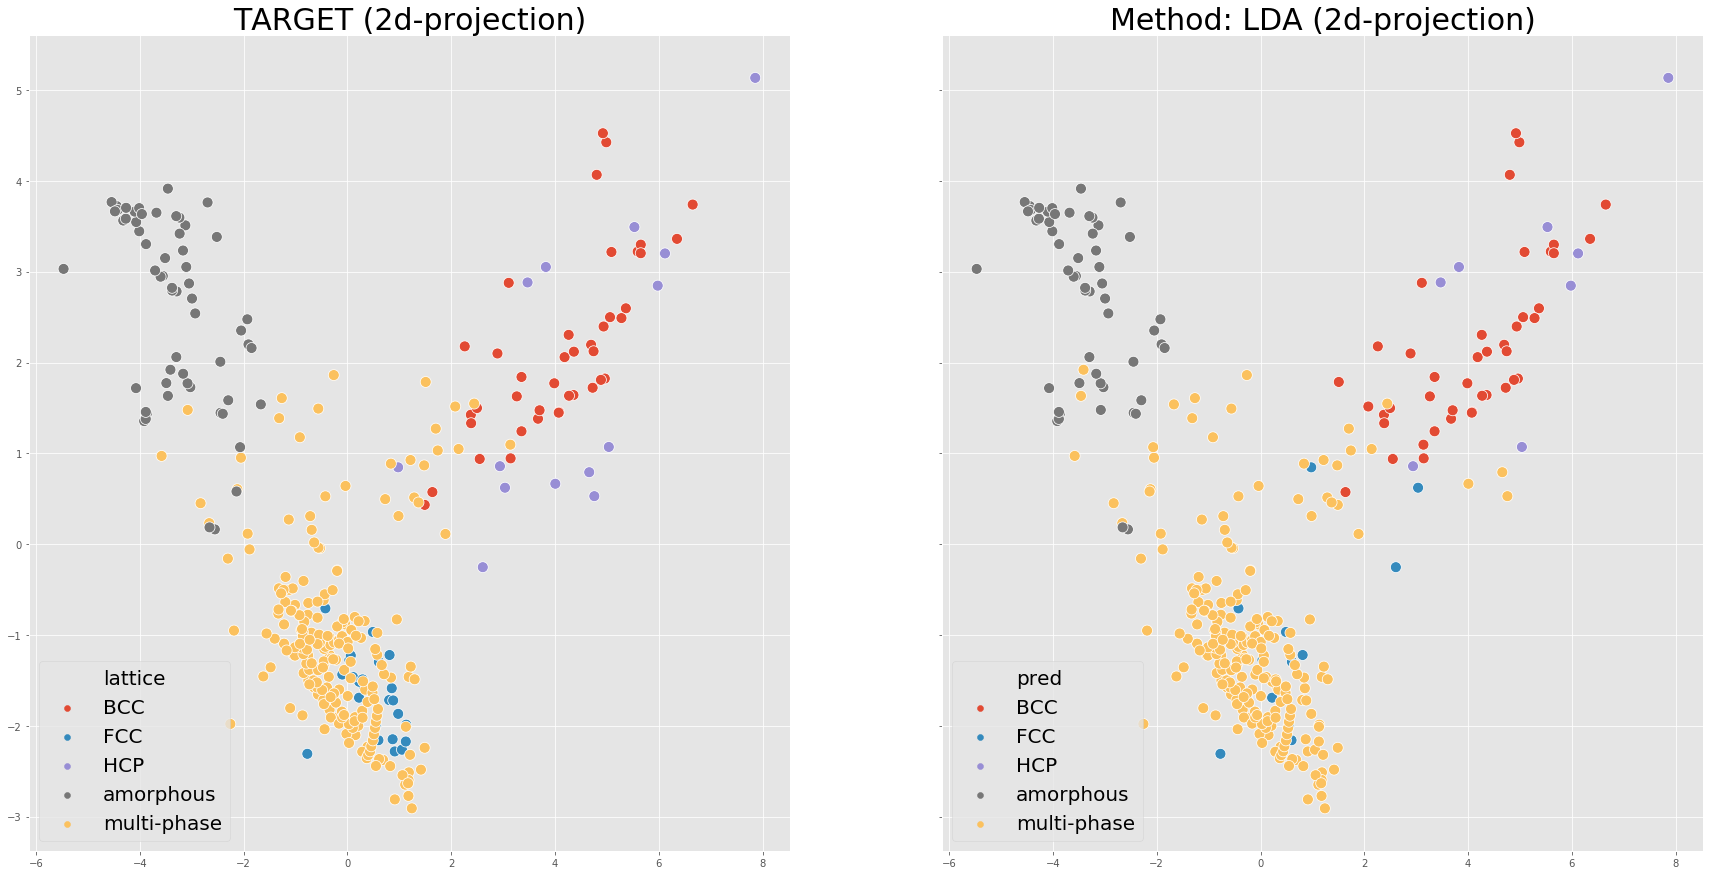

In [82]:
plot_pairviews(0, 1)

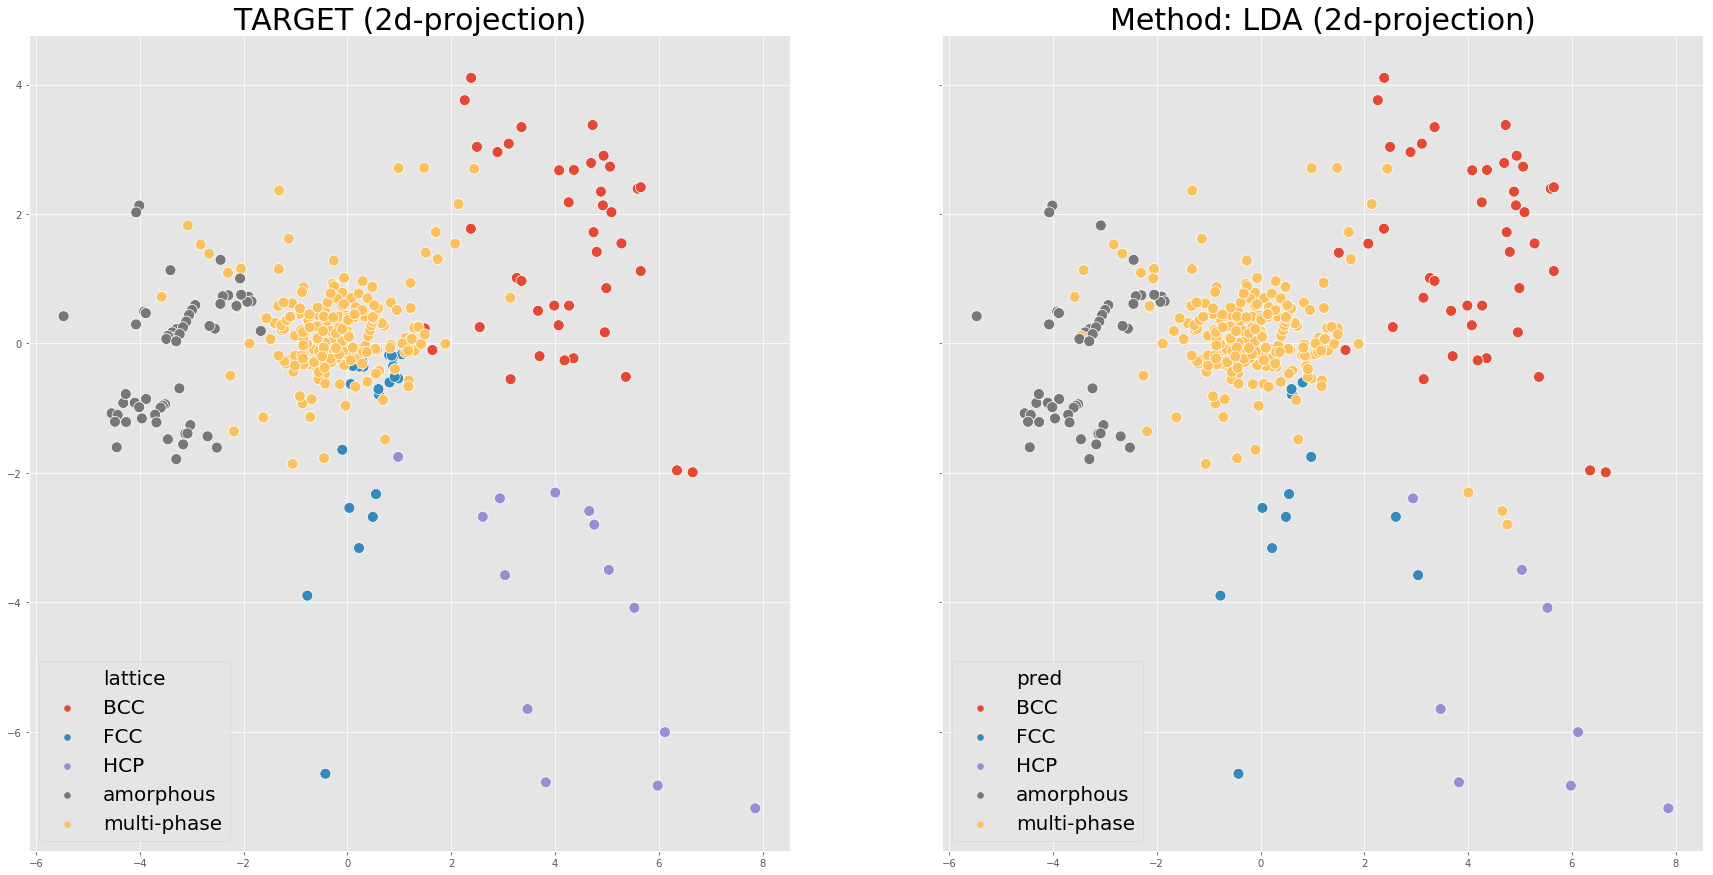

In [83]:
plot_pairviews(0, 2)

In [85]:
#plot_pairviews(1, 2)